# GADMA with custom model (momi)

GADMA could be run with a detailed specified demographic model. Model should be provided as a file with a function ``model_func`` that describes demographic history by engine itself. In case of ``momi`` engine it should take values of parameters and return ``momi``'s demographic model.

In this example we will take data and custom demographic model and infer its parameters with usage of GADMA and ``momi`` engine.

## Data

Assume two populations of modern human:

* YRI - African population,
* CEU - European population.

In this case we take the AFS data from Gutenkunst et al. 2009. Data is presented in file `YRI_CEU.fs` in ``dadi``'s SFS format. Fortunately, ``momi`` engine is able to read any format of SFS data. However if ``dadi``'s file is given to ``momi`` it should be in full format: with labels in the first line and comtain 3 lines in total.

## Demographic model

Demographic model is located in ``demographic_model.py`` and is written according to [``momi`` manual](https://momi2.readthedocs.io/en/latest/).

It is important to note that units of parameters for ``momi`` engine are `physical` by default. Time for one generation should be equal to 1 and time should be in generations. If we want to mark that one parameter is in `genetic` units then we add `_gen` at the end of its name (e.g. `nu_2F_gen`).

Time parameters should be used as usually in ``dadi`` as time of epochs. This means that past events should occur in sum of several time parameters (as time of ancestral population split happened at moment T+Tp).

In [1]:
%%bash
cat demographic_model.py

import momi
import numpy as np

def model_func(params):
    N_Anc, N_1F, r_2, nu_2F_gen, Tp, T = params

    model = momi.DemographicModel(N_e=1e5)

    model.add_leaf("YRI", N=N_1F)
    # we have nu_2F_gen is in genetic units so we translate it
    model.add_leaf("CEU", N=nu_2F_gen * N_Anc, g=r_2)
    # Time of population split is T
    model.move_lineages("CEU", "YRI", t=T, N=N_1F)
    # Time of ancestral size change is T + Tp
    model.set_size("YRI", N=N_Anc, g=0, t=T + Tp)

    return model



We could use some random parameters to plot this demographic model with ``momi``:

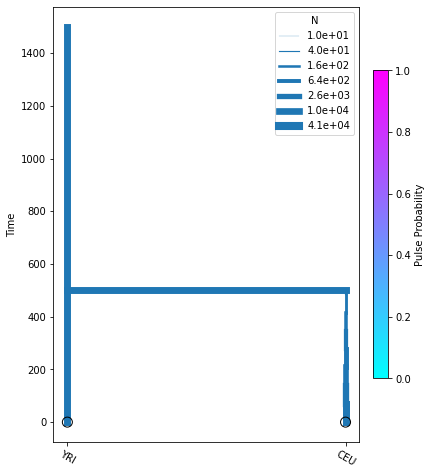

In [2]:
from demographic_model import model_func
import momi
rand_pars = [7000, 13000, 0.01, 2, 1000, 500]
model = model_func(rand_pars)
fig = momi.DemographyPlot(
    model, ["YRI", "CEU"],
    figsize=(6,8)
)

## Inference with GADMA

To run GADMA with custom model one should set parameters file:

In [3]:
%%bash
cat params_file

# Set data first
Input file: YRI_CEU.fs

# Output folder. It should be empty.
Output directory: gadma_result


# Set engine for simulations. We use momi.
Engine: momi

# For engine momi mutation rate and sequence length are required
Mutation rate: 2.35e-8
Sequence length: 4.04e6

# Now set our custom demographic model from file.
# There should be a function model_func in the file with a model.
Custom filename: demographic_model.py

# for short example
global_maxiter: 20

# How many repeats to run and how many processes to use.
Number of repeats: 2
Number of processes: 2


In [4]:
%%bash
# As output directory should be empty we remove it if it exists
rm -rf gadma_result

Now we can run GADMA:

In [5]:
%%bash
gadma -p params_file

Data reading
Number of populations: 2
Projections: [20, 20]
Population labels: ('YRI', 'CEU')
Outgroup: True
--Successful data reading--

--Successful arguments parsing--

Parameters of launch are saved in output directory: /home/katenos/Workspace/popgen/temp/GADMA/examples/custom_model_momi/gadma_result/params_file
All output is saved in output directory: /home/katenos/Workspace/popgen/temp/GADMA/examples/custom_model_momi/gadma_result/GADMA.log

--Start pipeline--
Run launch number 1
Run launch number 2

[000:01:00]
All best by log-likelihood models
Number	log-likelihood	Model
Run 2	-71390.07	(N_Anc=71174.729,	N_1F=59543.75892,	r_2=0.001,	nu_2F_gen=3.98626,	Tp=33144.24987,	T=5267.44531)	c	
Run 1	-74429.28	(N_Anc=543.23112,	N_1F=37311.12065,	r_2=-1.87e-06,	nu_2F_gen=1.91245,	Tp=120987.83849,	T=506.62639)	mmmm	
Run 2 warning: failed to draw model due to the following exception: Model <class 'gadma.models.custom_demographic_model.CustomDemographicModel'> is not supported by demes engine